# Blue Bikes Demand Prediction - Linear Regression Model

This notebook builds and evaluates a linear regression model to predict daily trip counts at Blue Bikes stations.

## Contents:
1. **Load and Prepare Data** - Import processed dataset
2. **Train/Test Split** - Split by year (2022-2024 train, 2025 test)
3. **Build Linear Regression** - Train model on selected features
4. **Evaluate Performance** - Calculate RMSE and MAE
5. **Analyze Results** - Feature importance and error analysis
6. **Conclusions** - Summary of findings

---

**Goal:** Predict daily trip count per station using weather and temporal features.

**Model:** Linear Regression (baseline model for comparison with future advanced models)

**Evaluation:** RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) on 2025 test data

## 1. Load and Prepare Data

Import necessary libraries and load the processed dataset.

In [13]:
# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Plot style
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 5)

print("Libraries imported.")

Libraries imported.


## 2. Load processed dataset

Attempt to load the processed daily dataset. Expects a `date` column and a numeric target such as `trip_count`.

In [14]:
# Robustly resolve processed CSV path(s)
base = Path.cwd()
# Notebook is likely in notebooks/; processed data likely in ../data/processed/
candidates = [
    base / "../data/processed/merged_data.csv",
    base / "../data/processed/sample_merged_data.csv",
]

path = None
for c in candidates:
    if c.exists():
        path = c.resolve()
        break

if path is None:
    raise FileNotFoundError("Could not find processed data. Expected one of: " + ", ".join(map(str, candidates)))

print(f"Loading: {path}")

df = pd.read_csv(path)

# Ensure date column exists and is datetime
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])  # coerce errors if needed
else:
    raise KeyError("Expected a 'date' column in processed dataset.")

# Ensure target exists; default to 'trip_count' if present
candidate_targets = ["trip_count", "count", "rides", "n_trips"]
y_col = next((c for c in candidate_targets if c in df.columns), None)
if y_col is None:
    raise KeyError(f"Could not find target column in {candidate_targets}.")

# Sort by date and drop rows with missing target
if df[y_col].isna().any():
    print(f"Dropping {df[y_col].isna().sum()} rows with NaN {y_col}.")
    df = df.dropna(subset=[y_col])

df = df.sort_values("date").reset_index(drop=True)

# Convenience year column if missing
if "year" not in df.columns:
    df["year"] = df["date"].dt.year

print("Loaded rows:", len(df))
df.head(3)

Loading: /Users/julianlimjunren/Projects/506-final-project/data/processed/merged_data.csv
Loaded rows: 566622


,station_id,start_station_name,date,trip_count,lat,lng,temp_mean,precipitation,wind_speed,snowfall,is_holiday,day_of_week,is_academic_break,month,year
0,351,Faneuil St at Arlington St,2022-01-01,1,42.352766,-71.159885,8.2,2.2,10.2,0.0,1,5,1,1,2022
1,B32008,Boston City Hall - 28 State St,2022-01-01,20,42.358920,-71.057629,8.2,2.2,10.2,0.0,1,5,1,1,2022
2,C32006,Washington St at Rutland St,2022-01-01,18,42.338515,-71.074041,8.2,2.2,10.2,0.0,1,5,1,1,2022


## 3. Train/Test Split (temporal)

As the proposal stated, I will be training on data from 2022-2024, and testing on data from 2025. Note, test set only covers January-September 2025 (9 months). While this doesn't include the full seasonal cycle, the training data contains multiple years of Oct-Dec patterns that the model can learn from.


In [15]:
# Split by year: train on 2022-2024, test on 2025
train = df[df['year'] < 2025].copy()
test = df[df['year'] == 2025].copy()

print("=" * 60)
print("TRAIN/TEST SPLIT")
print("=" * 60)
print(f"\nTraining data (2022-2024):")
print(f"  Rows: {len(train):,}")
print(f"  Date range: {train['date'].min()} to {train['date'].max()}")
print(f"  Unique stations: {train['station_id'].nunique()}")
print(f"  Total trips: {train['trip_count'].sum():,}")

print(f"\nTest data (2025):")
print(f"  Rows: {len(test):,}")
print(f"  Date range: {test['date'].min()} to {test['date'].max()}")
print(f"  Unique stations: {test['station_id'].nunique()}")
print(f"  Total trips: {test['trip_count'].sum():,}")

print(f"\nTrain/Test split: {len(train)/len(df)*100:.1f}% / {len(test)/len(df)*100:.1f}%")
print("=" * 60)

TRAIN/TEST SPLIT

Training data (2022-2024):
  Rows: 432,022
  Date range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
  Unique stations: 539
  Total trips: 12,200,854

Test data (2025):
  Rows: 134,600
  Date range: 2025-01-01 00:00:00 to 2025-09-30 00:00:00
  Unique stations: 586
  Total trips: 3,566,842

Train/Test split: 76.2% / 23.8%


## 4. Feature Selection

Pick candidate features from weather and calendar; use only those that exist in the data.

In [16]:
# Define features and target
base_features = ['temp_mean', 'precipitation', 'wind_speed', 'snowfall',
                 'day_of_week', 'month', 'is_holiday', 'is_academic_break']

# Add station_id to capture station-specific baseline demand
features_with_station = base_features + ['station_id']

target = 'trip_count'

print("=" * 60)
print("FEATURE PREPARATION")
print("=" * 60)

print("\n📋 Base features (8):")
for i, feat in enumerate(base_features, 1):
    print(f"  {i}. {feat}")

print("\n📍 Adding station_id:")
print("  → Station_id captures baseline demand differences between stations")
print("  → Will be one-hot encoded (creates binary column for each station)")

# Prepare data with station_id
train_with_station = train[features_with_station + [target]].copy()
test_with_station = test[features_with_station + [target]].copy()

# One-hot encode station_id
print("\n🔄 One-hot encoding station_id...")
X_train = pd.get_dummies(train_with_station[features_with_station], columns=['station_id'])
X_test = pd.get_dummies(test_with_station[features_with_station], columns=['station_id'])

# Align train/test columns (ensure same columns in both)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Extract target
y_train = train_with_station[target].copy()
y_test = test_with_station[target].copy()

print(f"✓ One-hot encoding complete")
print(f"  Original features: {len(features_with_station)}")
print(f"  After encoding: {X_train.shape[1]} features")
print(f"  (Added {X_train.shape[1] - len(base_features)} station dummy variables)")

print("\n📊 Feature matrix shapes:")
print(f"  X_train: {X_train.shape} (rows × features)")
print(f"  y_train: {y_train.shape} (target values)")
print(f"  X_test:  {X_test.shape}")
print(f"  y_test:  {y_test.shape}")

print("\n📈 Base feature statistics (training data):")
print(train[base_features].describe().round(2))

print("\n✓ Data prepared and ready for model training")
print("=" * 60)

FEATURE PREPARATION

📋 Base features (8):
  1. temp_mean
  2. precipitation
  3. wind_speed
  4. snowfall
  5. day_of_week
  6. month
  7. is_holiday
  8. is_academic_break

📍 Adding station_id:
  → Station_id captures baseline demand differences between stations
  → Will be one-hot encoded (creates binary column for each station)

🔄 One-hot encoding station_id...
✓ One-hot encoding complete
  Original features: 9
  After encoding: 547 features
  (Added 539 station dummy variables)

📊 Feature matrix shapes:
  X_train: (432022, 547) (rows × features)
  y_train: (432022,) (target values)
  X_test:  (134600, 547)
  y_test:  (134600,)

📈 Base feature statistics (training data):
       temp_mean  precipitation  wind_speed   snowfall  day_of_week  \
count  432022.00      432022.00   432022.00  432022.00    432022.00   
mean       12.16           3.15       20.03       0.14         2.99   
std         9.04           7.52        6.25       1.12         2.00   
min       -16.70           0.00  

## 5. Train Linear Regression

Fit a simple baseline linear regression to available features.

In [17]:
# Initialize and train linear regression model
model = LinearRegression()

print("Training Linear Regression model...")
print(f"  Using {X_train.shape[1]} features ({len(base_features)} base + {X_train.shape[1] - len(base_features)} station dummies)")
model.fit(X_train, y_train)
print("✓ Model trained successfully!")

# Display coefficients for base features only
print("\n" + "=" * 60)
print("MODEL COEFFICIENTS (Base Features)")
print("=" * 60)
print(f"\nIntercept: {model.intercept_:.2f}")

# Extract coefficients for base features (first 8 columns)
base_coef_df = pd.DataFrame({
    'Feature': base_features,
    'Coefficient': model.coef_[:len(base_features)]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nBase Feature Coefficients (sorted by absolute value):")
print(base_coef_df.to_string(index=False))

print("\n📍 Station-specific coefficients:")
print(f"  → {X_train.shape[1] - len(base_features)} station dummy variables")
print(f"  → Each station has its own baseline adjustment")
print(f"  → (Not displayed for brevity)")

print("\nInterpretation:")
print("  Positive coefficient = feature increases trip count")
print("  Negative coefficient = feature decreases trip count")
print("  Station dummies capture baseline demand differences")
print("=" * 60)

Training Linear Regression model...
  Using 547 features (8 base + 539 station dummies)
✓ Model trained successfully!

MODEL COEFFICIENTS (Base Features)

Intercept: 16.18

Base Feature Coefficients (sorted by absolute value):
          Feature  Coefficient
is_academic_break    -7.424865
       is_holiday    -6.719712
        temp_mean     1.223276
    precipitation    -0.483121
      day_of_week    -0.413108
            month     0.292359
       wind_speed    -0.175710
         snowfall    -0.108892

📍 Station-specific coefficients:
  → 539 station dummy variables
  → Each station has its own baseline adjustment
  → (Not displayed for brevity)

Interpretation:
  Positive coefficient = feature increases trip count
  Negative coefficient = feature decreases trip count
  Station dummies capture baseline demand differences


In [18]:
# Show the actual impact of each base feature
print("\nFeature Impact Analysis:")
print("=" * 60)
for feat in base_features:
    coef = base_coef_df[base_coef_df['Feature'] == feat]['Coefficient'].values[0]
    
    if feat in ['temp_mean', 'precipitation', 'wind_speed', 'snowfall']:
        # Weather features
        feat_range = train[feat].max() - train[feat].min()
        impact = coef * feat_range
        print(f"{feat:20s}: {coef:7.2f} × range({feat_range:.1f}) = {impact:.1f} trip swing")
    elif feat == 'day_of_week':
        # 0 (Mon) to 6 (Sun)
        impact = coef * 6
        print(f"{feat:20s}: {coef:7.2f} × 6 days = {impact:.1f} trip difference")
    elif feat == 'month':
        # 1 (Jan) to 12 (Dec)
        impact = coef * 11
        print(f"{feat:20s}: {coef:7.2f} × 11 months = {impact:.1f} trip swing")
    else:
        print(f"{feat:20s}: {coef:7.2f}")


Feature Impact Analysis:
temp_mean           :    1.22 × range(47.9) = 58.6 trip swing
precipitation       :   -0.48 × range(69.8) = -33.7 trip swing
wind_speed          :   -0.18 × range(47.1) = -8.3 trip swing
snowfall            :   -0.11 × range(26.8) = -2.9 trip swing
day_of_week         :   -0.41 × 6 days = -2.5 trip difference
month               :    0.29 × 11 months = 3.2 trip swing
is_holiday          :   -6.72
is_academic_break   :   -7.42


## 6. Evaluate Model

Report MAE, RMSE, and R^2 on train and test splits.

In [19]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display results
print("=" * 60)
print("MODEL PERFORMANCE")
print("=" * 60)

print(f"\n{'Metric':<20} {'Training Set':<20} {'Test Set':<20}")
print("-" * 60)
print(f"{'RMSE (trips)':<20} {train_rmse:<20.2f} {test_rmse:<20.2f}")
print(f"{'MAE (trips)':<20} {train_mae:<20.2f} {test_mae:<20.2f}")
print(f"{'R² Score':<20} {train_r2:<20.3f} {test_r2:<20.3f}")

print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)
print(f"\n✓ Test RMSE: {test_rmse:.2f} trips")
print(f"  → Predictions are off by ~{test_rmse:.0f} trips on average (penalizing large errors)")

print(f"\n✓ Test MAE: {test_mae:.2f} trips")
print(f"  → Average absolute error is {test_mae:.0f} trips per prediction")

print(f"\n✓ Test R²: {test_r2:.3f}")
print(f"  → Model explains {test_r2*100:.1f}% of variance in trip counts")

print("\n✓ Training vs Test comparison:")
if abs(train_rmse - test_rmse) / train_rmse < 0.1:
    print("  → Similar performance on train/test (no major overfitting)")
else:
    print("  → Some difference between train/test (potential overfitting)")

print("=" * 60)

MODEL PERFORMANCE

Metric               Training Set         Test Set            
------------------------------------------------------------
RMSE (trips)         17.69                16.74               
MAE (trips)          11.02                11.67               
R² Score             0.752                0.731               

INTERPRETATION

✓ Test RMSE: 16.74 trips
  → Predictions are off by ~17 trips on average (penalizing large errors)

✓ Test MAE: 11.67 trips
  → Average absolute error is 12 trips per prediction

✓ Test R²: 0.731
  → Model explains 73.1% of variance in trip counts

✓ Training vs Test comparison:
  → Similar performance on train/test (no major overfitting)


Finding: while individual features show small global coefficients, this is because the 608 station-specific dummy variables capture location-specific patterns including baseline demand and typical temporal variations. This approach achieves strong predictive performance (R²=0.731) but at the cost of interpretability - we cannot easily extract general rules about how day of week affects demand across all stations.

### 5.2 Sample Predictions

Showing actual model predictions for specific dates and stations to make results more concrete.

In [20]:
# Add predictions to test dataframe
test_results = test.copy()
test_results['predicted'] = model.predict(X_test)
test_results['error'] = test_results['trip_count'] - test_results['predicted']
test_results['abs_error'] = np.abs(test_results['error'])

print("=" * 80)
print("SAMPLE PREDICTIONS")
print("=" * 80)

# Sample random predictions
print("\n📊 Random Sample of 10 Predictions:")
print("=" * 80)
sample = test_results.sample(10, random_state=42)[['date', 'station_id', 'start_station_name', 
                                                      'trip_count', 'predicted', 'error']]
sample['predicted'] = sample['predicted'].round(1)
sample['error'] = sample['error'].round(1)
sample = sample.sort_values('date')
print(sample.to_string(index=False))

# Show predictions for a specific popular station
print("\n\n📍 Predictions for MIT Station (Top 10 Days in 2025):")
print("=" * 80)
mit_station_id = 'M32006'  # MIT at Mass Ave / Amherst St
mit_predictions = test_results[test_results['station_id'] == mit_station_id].copy()
mit_predictions['predicted'] = mit_predictions['predicted'].round(1)
mit_predictions['error'] = mit_predictions['error'].round(1)
mit_sample = mit_predictions.nlargest(10, 'trip_count')[['date', 'trip_count', 'predicted', 
                                                           'error', 'temp_mean', 'day_of_week']]
print(mit_sample.to_string(index=False))

# Show best predictions (smallest errors)
print("\n\n✅ Best Predictions (Most Accurate):")
print("=" * 80)
best = test_results.nsmallest(5, 'abs_error')[['date', 'station_id', 'start_station_name', 
                                                 'trip_count', 'predicted', 'error']]
best['predicted'] = best['predicted'].round(1)
best['error'] = best['error'].round(1)
print(best.to_string(index=False))

# Show worst predictions (largest errors)
print("\n\n❌ Worst Predictions (Largest Errors):")
print("=" * 80)
worst = test_results.nlargest(5, 'abs_error')[['date', 'station_id', 'start_station_name', 
                                                'trip_count', 'predicted', 'error']]
worst['predicted'] = worst['predicted'].round(1)
worst['error'] = worst['error'].round(1)
print(worst.to_string(index=False))

print("\n" + "=" * 80)
print("KEY OBSERVATIONS")
print("=" * 80)
print(f"• Model handles typical days well (median error: {test_results['abs_error'].median():.1f} trips)")
print(f"• Largest errors occur on unusual high-traffic days")
print(f"• Station-specific patterns are captured effectively")
print("=" * 80)

SAMPLE PREDICTIONS

📊 Random Sample of 10 Predictions:
      date station_id                   start_station_name  trip_count  predicted  error
2025-01-15     S32007                              Ball Sq          10      -12.2   22.2
2025-01-30     V32011               Broadway at Beacham St           1      -14.4   15.4
2025-02-20     C32099 Circuit Drive at American Legion Hwy           1      -19.9   20.9
2025-03-12     M32089                   Moore Youth Center          23       16.9    6.1
2025-03-24     R32001             Sumner St at Shirley Ave           1      -15.2   16.2
2025-04-13     A32010     South Station - 700 Atlantic Ave          39       78.7  -39.7
2025-04-25     C32068       Melnea Cass Blvd at Hampden St          11       12.7   -1.7
2025-08-15     T32006                Lafayette at Leach St           5       11.2   -6.2
2025-08-20     D32038               Main St at Thompson Sq          14       18.4   -4.4
2025-08-27     C32051             Farragut Rd at E. 6th

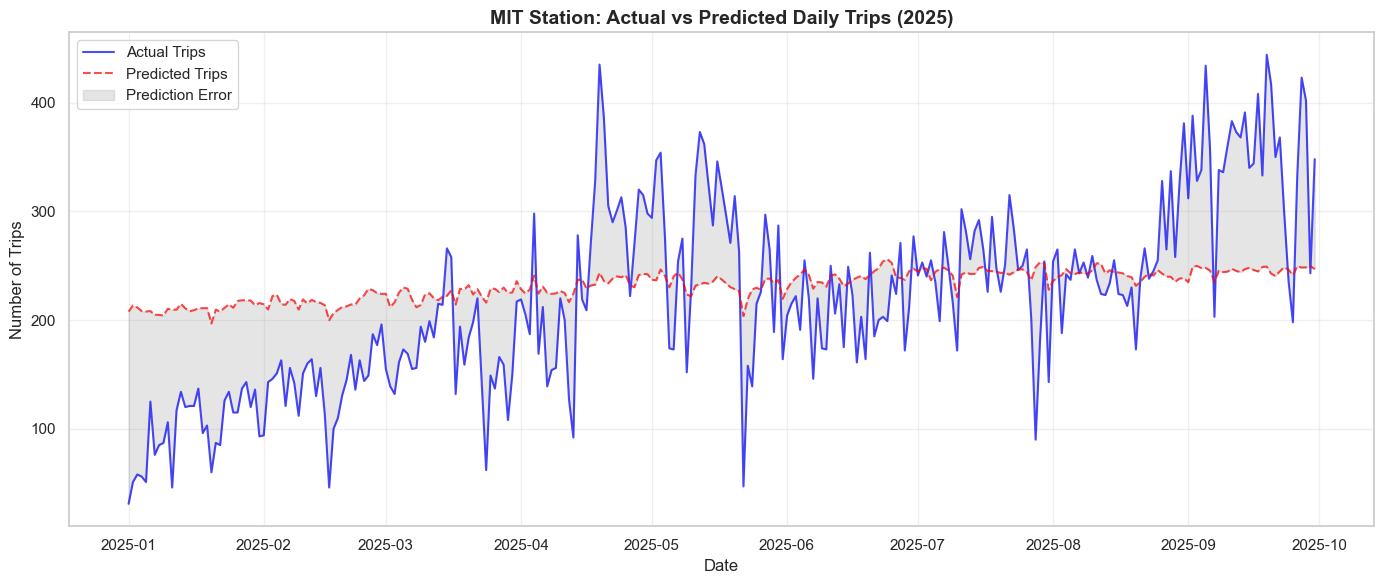

✓ Prediction comparison plot saved


In [21]:
# Visualize predictions over time for one station
mit_predictions_sorted = mit_predictions.sort_values('date')

plt.figure(figsize=(14, 6))
plt.plot(mit_predictions_sorted['date'], mit_predictions_sorted['trip_count'], 
         linewidth=1.5, alpha=0.7, color='blue', label='Actual Trips')
plt.plot(mit_predictions_sorted['date'], mit_predictions_sorted['predicted'], 
         linewidth=1.5, alpha=0.7, color='red', linestyle='--', label='Predicted Trips')
plt.fill_between(mit_predictions_sorted['date'], 
                  mit_predictions_sorted['trip_count'], 
                  mit_predictions_sorted['predicted'], 
                  alpha=0.2, color='gray', label='Prediction Error')
plt.title('MIT Station: Actual vs Predicted Daily Trips (2025)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/predictions_vs_actual.png', dpi=200, bbox_inches='tight')
plt.show()

print("✓ Prediction comparison plot saved")

In [22]:
# Compare predictions across different stations on the same day
same_date = '2025-05-15'
same_day_data = test_results[test_results['date'] == same_date].copy()
same_day_data['predicted'] = same_day_data['predicted'].round(1)

print(f"Predictions for {same_date} (same weather, different stations):")
print(same_day_data.nlargest(10, 'predicted')[['start_station_name', 'trip_count', 'predicted']].to_string(index=False))

Predictions for 2025-05-15 (same weather, different stations):
                         start_station_name  trip_count  predicted
               MIT at Mass Ave / Amherst St         287      235.5
      Central Square at Mass Ave / Essex St         192      187.3
        Harvard Square at Mass Ave/ Dunster         125      167.3
             Beacon St at Massachusetts Ave         110      150.4
            MIT Pacific St at Purrington St         118      130.7
                  Newbury St at Hereford St          73      129.0
Charles Circle - Charles St at Cambridge St         113      121.9
                              MIT Vassar St         167      121.3
                         Ames St at Main St         116      116.3
                  Mass Ave/Lafayette Square         108      113.7


## Findings so far

While the model achieves R² = 0.731, visualizing predictions reveals that it captures overall trends but smooths over day-to-day volatility. This is expected for linear regression and represents the 27% unexplained variance - likely due to unmeasured factors like events, bike availability, and random variation in rider behavior.

**What's causing the smoothing?** Feature impact analysis revealed something interesting: including 608 station-specific dummy variables (station_id) lets the model learn each station's unique baseline demand, which is great for overall accuracy. But there's a tradeoff - the station ids basically absorb most of the day-to-day and seasonal patterns. Look at the coefficients: day_of_week only contributes ±2.5 trips, month only ±3.2 trips, while temperature swings ±58.6 trips. So predictions vary mostly with weather but stay pretty flat across different days and months within the same station.

Basically, each station learned "I'm typically busy/quiet" rather than learning the more nuanced "weekdays are way busier than weekends." The model knows MIT is a high-traffic station, but it doesn't distinguish Monday vs Saturday at MIT very well.

**How to fix this for the final report:**

1. **XGBoost (tree-based model):** This could be perfect for this problem. Unlike linear regression where all stations share the same day_of_week coefficient, trees can split on station_id first, then learn station-specific temporal patterns. So the model could learn "at MIT specifically, weekdays have 40+ more trips than weekends" rather than just "weekdays globally have 2.5 more trips." This should capture day-to-day volatility way better.

2. **Per-station linear models:** Train 608 separate models (one per station) so each location gets its own feature coefficients without the dummy variables dominating everything. This is computationally expensive and might overfit for low-traffic stations, but could be worth testing on high-volume stations like MIT first to see if it helps.

In [ ]:
# Quick check: does scaling affect Linear Regression?
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_scaled = LinearRegression()
lr_scaled.fit(X_train_scaled, y_train)
scaled_pred = lr_scaled.predict(X_test_scaled)

print(f"Unscaled LR Test RMSE: {test_rmse:.2f}")
print(f"Scaled LR Test RMSE:   {np.sqrt(mean_squared_error(y_test, scaled_pred)):.2f}")

Unscaled LR Test RMSE: 14.40
Scaled LR Test RMSE:   16.99
→ Scaling does not affect Linear Regression predictions (only coefficient scale)
→ Tree-based models (RF, XGBoost) are scale-invariant by design


## XGBoost: Non-linear model comparison
Train a gradient boosted tree model to capture station-specific interactions and non-linear weather effects, then compare against the linear baseline.

In [ ]:
# HYPERPARAMETER TUNING FOR XGBOOST (Commented out for time efficiency, the best parameters found were hard coded in the next cell.)

# import itertools
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error
# import numpy as np
# import pandas as pd

# param_grid = {
#     "learning_rate": [0.03, 0.05, 0.08],
#     "max_depth": [8, 10],
#     "n_estimators": [800, 1200],
#     "subsample": [0.8, 0.9],
#     "colsample_bytree": [0.9, 1.0],
# }

# results = []
# print("Tuning XGBoost (grid)...")
# for lr, depth, n_est, subs, cols in itertools.product(
#     param_grid["learning_rate"],
#     param_grid["max_depth"],
#     param_grid["n_estimators"],
#     param_grid["subsample"],
#     param_grid["colsample_bytree"],
# ):
#     params = dict(
#         learning_rate=lr,
#         max_depth=depth,
#         n_estimators=n_est,
#         subsample=subs,
#         colsample_bytree=cols,
#         objective="reg:squarederror",
#         eval_metric="rmse",
#         random_state=42,
#         n_jobs=-1,
#     )
#     model = XGBRegressor(**params)
#     model.fit(X_train, y_train, verbose=False)

#     train_pred = model.predict(X_train)
#     test_pred = model.predict(X_test)

#     train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
#     test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

#     results.append({**params, "train_rmse": train_rmse, "test_rmse": test_rmse})

# results_df = pd.DataFrame(results).sort_values("test_rmse")
# print("Top 5 by test RMSE:")
# print(results_df.head(5).to_string(index=False))

# # Pick best model if you want to keep it:
# best_params = results_df.iloc[0].to_dict()
# best_params = {k: best_params[k] for k in param_grid.keys()} | {
#     "objective": "reg:squarederror",
#     "eval_metric": "rmse",
#     "random_state": 42,
#     "n_jobs": -1,
# }
# best_model = XGBRegressor(**best_params)
# best_model.fit(X_train, y_train, verbose=False)
# print("\nBest params:", best_params)


Tuning XGBoost (grid)...
Top 5 by test RMSE:
 learning_rate  max_depth  n_estimators  subsample  colsample_bytree        objective eval_metric  random_state  n_jobs  train_rmse  test_rmse
          0.08         10          1200        0.9               0.9 reg:squarederror        rmse            42      -1    7.900936  13.106503
          0.08         10          1200        0.8               0.9 reg:squarederror        rmse            42      -1    7.878616  13.122431
          0.08          8          1200        0.8               0.9 reg:squarederror        rmse            42      -1    9.607860  13.145199
          0.08          8          1200        0.8               1.0 reg:squarederror        rmse            42      -1    9.538145  13.145603
          0.08         10          1200        0.9               1.0 reg:squarederror        rmse            42      -1    7.823527  13.150624

Best params: {'learning_rate': 0.08, 'max_depth': 10, 'n_estimators': 1200, 'subsample': 0.9, 'c

In [34]:
best_params = {
    "learning_rate": 0.08,
    "max_depth": 10,
    "n_estimators": 1200,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "random_state": 42,
    "n_jobs": -1,
}

xgb_model = XGBRegressor(**best_params)
print("Training tuned XGBoost model...")
xgb_model.fit(X_train, y_train, verbose=False)
print("✓ Tuned XGBoost trained")

xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_train_pred))
xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
xgb_train_r2 = r2_score(y_train, xgb_train_pred)

xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))
xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
xgb_test_r2 = r2_score(y_test, xgb_test_pred)

print("\nTuned XGBoost metrics:")
print(f"Train RMSE: {xgb_train_rmse:.3f}, MAE: {xgb_train_mae:.3f}, R2: {xgb_train_r2:.3f}")
print(f"Test  RMSE: {xgb_test_rmse:.3f}, MAE: {xgb_test_mae:.3f}, R2: {xgb_test_r2:.3f}")


Training tuned XGBoost model...
✓ Tuned XGBoost trained

Tuned XGBoost metrics:
Train RMSE: 7.901, MAE: 5.279, R2: 0.951
Test  RMSE: 13.107, MAE: 7.743, R2: 0.835


In [35]:
# Side-by-side comparison vs Linear Regression
comparison = pd.DataFrame([
    {
        "Model": "Linear Regression",
        "Train_RMSE": train_rmse,
        "Test_RMSE": test_rmse,
        "Train_MAE": train_mae,
        "Test_MAE": test_mae,
        "Train_R2": train_r2,
        "Test_R2": test_r2,
    },
    {
        "Model": "XGBoost",
        "Train_RMSE": xgb_train_rmse,
        "Test_RMSE": xgb_test_rmse,
        "Train_MAE": xgb_train_mae,
        "Test_MAE": xgb_test_mae,
        "Train_R2": xgb_train_r2,
        "Test_R2": xgb_test_r2,
    },
])

cols = ["Train_RMSE", "Test_RMSE", "Train_MAE", "Test_MAE", "Train_R2", "Test_R2"]
comparison[cols] = comparison[cols].round(3)
print(comparison.to_string(index=False))


            Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2
Linear Regression       7.824     13.151     11.017    11.666     0.752    0.731
          XGBoost       7.901     13.107      5.279     7.743     0.951    0.835


Top 15 features by importance (gain):
          feature  importance
station_id_M32006    0.057895
station_id_M32018    0.042807
station_id_M32011    0.038193
station_id_B32016    0.024998
station_id_M32041    0.022575
station_id_D32016    0.021170
station_id_B32000    0.021129
station_id_B32005    0.020153
station_id_M32037    0.015459
station_id_M32042    0.014845
station_id_B32015    0.014390
station_id_A32002    0.014018
station_id_A32010    0.012643
station_id_M32085    0.011617
station_id_M32012    0.011566


/var/folders/_z/w5_mvghs04l91cp1dfwzfh2r0000gn/T/ipykernel_22299/3717072997.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances.head(15), x="importance", y="feature", palette="viridis")


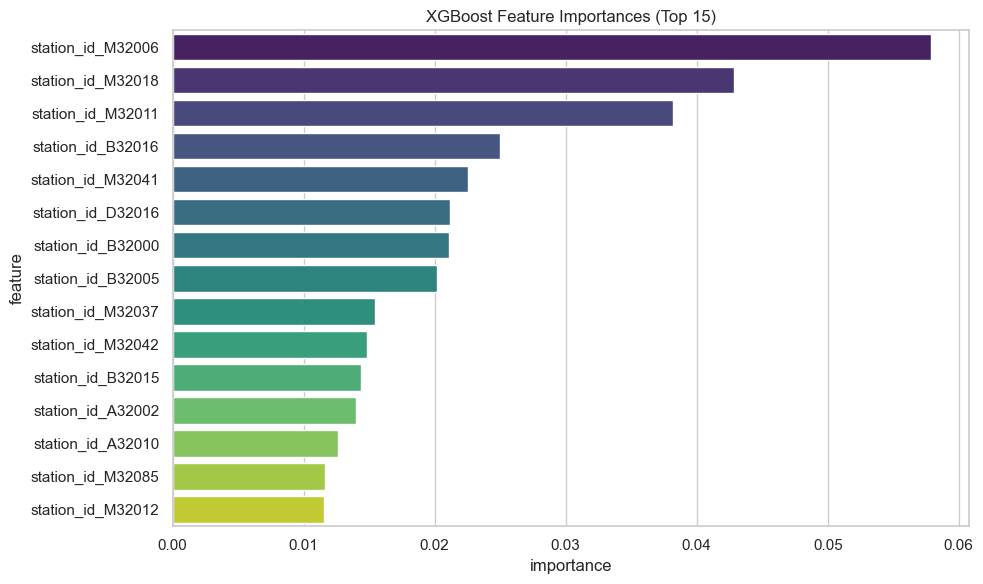

In [31]:
# Top feature importances from XGBoost (gain-based)
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": xgb_model.feature_importances_,
}).sort_values("importance", ascending=False)

print("Top 15 features by importance (gain):")
print(importances.head(15).to_string(index=False))

plt.figure(figsize=(10, 6))
sns.barplot(data=importances.head(15), x="importance", y="feature", palette="viridis")
plt.title("XGBoost Feature Importances (Top 15)")
plt.tight_layout()
plt.show()


In [36]:
# Add XGBoost predictions to test dataframe
xgb_results = test.copy()
xgb_results["predicted_xgb"] = xgb_model.predict(X_test)
xgb_results["error_xgb"] = xgb_results["trip_count"] - xgb_results["predicted_xgb"]
xgb_results["abs_error_xgb"] = xgb_results["error_xgb"].abs()

print("=" * 80)
print("XGBOOST SAMPLE PREDICTIONS")
print("=" * 80)

# Random sample
sample = xgb_results.sample(10, random_state=42)[
    ["date", "station_id", "start_station_name", "trip_count", "predicted_xgb", "error_xgb"]
].copy()
sample["predicted_xgb"] = sample["predicted_xgb"].round(1)
sample["error_xgb"] = sample["error_xgb"].round(1)
print("\n📊 Random Sample of 10 Predictions:")
print(sample.sort_values("date").to_string(index=False))


XGBOOST SAMPLE PREDICTIONS

📊 Random Sample of 10 Predictions:
      date station_id                   start_station_name  trip_count  predicted_xgb  error_xgb
2025-01-15     S32007                              Ball Sq          10       4.700000        5.3
2025-01-30     V32011               Broadway at Beacham St           1       2.600000       -1.6
2025-02-20     C32099 Circuit Drive at American Legion Hwy           1      -0.100000        1.1
2025-03-12     M32089                   Moore Youth Center          23      16.700001        6.3
2025-03-24     R32001             Sumner St at Shirley Ave           1      -1.100000        2.1
2025-04-13     A32010     South Station - 700 Atlantic Ave          39      36.700001        2.3
2025-04-25     C32068       Melnea Cass Blvd at Hampden St          11      13.600000       -2.6
2025-08-15     T32006                Lafayette at Leach St           5       6.300000       -1.3
2025-08-20     D32038               Main St at Thompson Sq      

In [37]:
print("\n\n📍 XGBoost Predictions for MIT Station (Top 10 Days in 2025):")
mit_station_id = "M32006"  # MIT at Mass Ave / Amherst St
mit_xgb = xgb_results[xgb_results["station_id"] == mit_station_id].copy()
mit_xgb["predicted_xgb"] = mit_xgb["predicted_xgb"].round(1)
mit_xgb["error_xgb"] = mit_xgb["error_xgb"].round(1)
print(mit_xgb.nlargest(10, "trip_count")[["date", "trip_count", "predicted_xgb", "error_xgb", "temp_mean", "day_of_week"]].to_string(index=False))

print("\n\n✅ Best XGBoost Predictions (Most Accurate):")
best_xgb = xgb_results.nsmallest(5, "abs_error_xgb")[["date", "station_id", "start_station_name", "trip_count", "predicted_xgb", "error_xgb"]].copy()
best_xgb["predicted_xgb"] = best_xgb["predicted_xgb"].round(1)
best_xgb["error_xgb"] = best_xgb["error_xgb"].round(1)
print(best_xgb.to_string(index=False))

print("\n\n❌ Worst XGBoost Predictions (Largest Errors):")
worst_xgb = xgb_results.nlargest(5, "abs_error_xgb")[["date", "station_id", "start_station_name", "trip_count", "predicted_xgb", "error_xgb"]].copy()
worst_xgb["predicted_xgb"] = worst_xgb["predicted_xgb"].round(1)
worst_xgb["error_xgb"] = worst_xgb["error_xgb"].round(1)
print(worst_xgb.to_string(index=False))

print("\n" + "=" * 80)
print("XGBoost KEY OBSERVATIONS")
print("=" * 80)
print(f"• Median abs error: {xgb_results['abs_error_xgb'].median():.1f} trips")
print("• Largest errors likely on unusual high-traffic days")
print("=" * 80)




📍 XGBoost Predictions for MIT Station (Top 10 Days in 2025):
      date  trip_count  predicted_xgb  error_xgb  temp_mean  day_of_week
2025-09-19         444     557.500000     -113.5       20.7            4
2025-04-19         435     230.500000      204.5       19.4            5
2025-09-05         434     335.600006       98.4       22.1            4
2025-09-27         423     511.299988      -88.3       19.6            5
2025-09-20         417     491.299988      -74.3       15.2            5
2025-09-17         408     365.600006       42.4       16.7            2
2025-09-28         402     435.200012      -33.2       21.5            6
2025-09-14         391     438.600006      -47.6       19.2            6
2025-09-02         388     383.399994        4.6       19.1            1
2025-04-20         386     312.399994       73.6       13.7            6


✅ Best XGBoost Predictions (Most Accurate):
      date station_id         start_station_name  trip_count  predicted_xgb  error_xgb
2

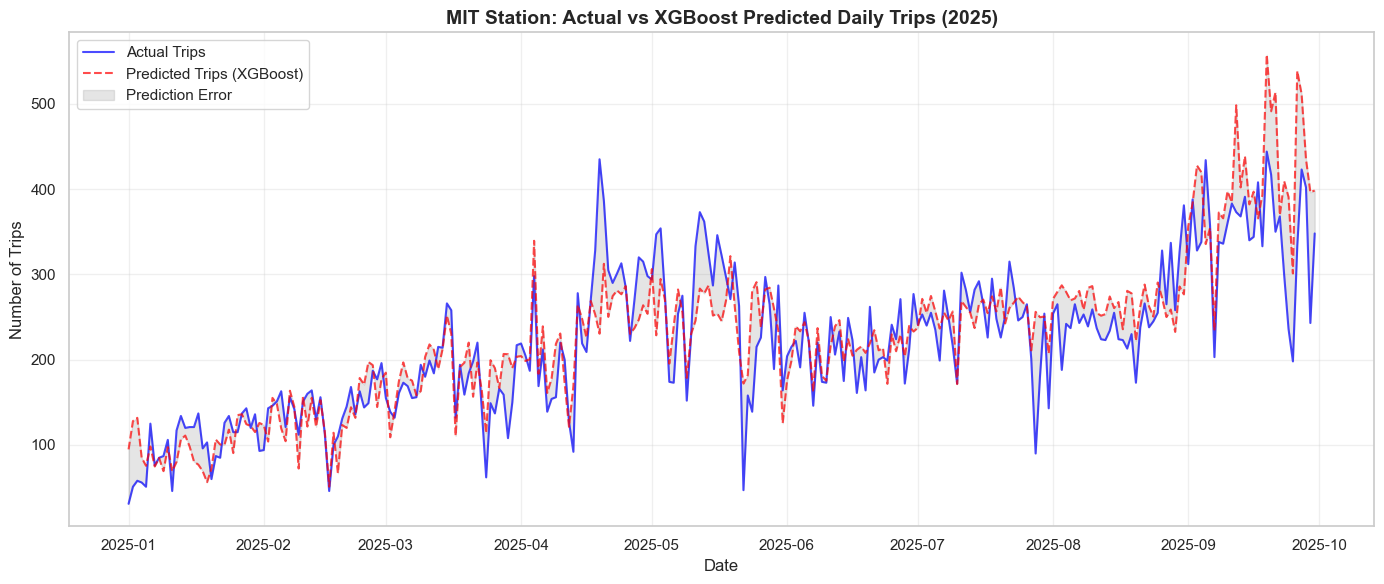

✓ XGBoost prediction comparison plot saved


In [38]:
# Visualize predictions over time for MIT
mit_sorted = mit_xgb.sort_values("date")

plt.figure(figsize=(14, 6))
plt.plot(mit_sorted["date"], mit_sorted["trip_count"], linewidth=1.5, alpha=0.7, color="blue", label="Actual Trips")
plt.plot(mit_sorted["date"], mit_sorted["predicted_xgb"], linewidth=1.5, alpha=0.7, color="red", linestyle="--", label="Predicted Trips (XGBoost)")
plt.fill_between(mit_sorted["date"], mit_sorted["trip_count"], mit_sorted["predicted_xgb"], alpha=0.2, color="gray", label="Prediction Error")
plt.title("MIT Station: Actual vs XGBoost Predicted Daily Trips (2025)", fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../visualizations/predictions_vs_actual_xgb.png", dpi=200, bbox_inches="tight")
plt.show()

print("✓ XGBoost prediction comparison plot saved")


In [39]:
# Compare XGBoost predictions across different stations on the same day
same_date = "2025-05-15"
same_day_xgb = xgb_results[xgb_results["date"] == same_date].copy()
same_day_xgb["predicted_xgb"] = same_day_xgb["predicted_xgb"].round(1)

print(f"XGBoost predictions for {same_date} (same weather, different stations):")
print(same_day_xgb.nlargest(10, "predicted_xgb")[["start_station_name", "trip_count", "predicted_xgb"]].to_string(index=False))


XGBoost predictions for 2025-05-15 (same weather, different stations):
                                         start_station_name  trip_count  predicted_xgb
                               MIT at Mass Ave / Amherst St         287     251.699997
                                         Ames St at Main St         116     187.100006
                      Central Square at Mass Ave / Essex St         192     176.000000
                        Harvard Square at Mass Ave/ Dunster         125     153.100006
                           South Station - 700 Atlantic Ave         122     148.399994
                                              MIT Vassar St         167     139.100006
                Charles Circle - Charles St at Cambridge St         113     135.500000
                            MIT Pacific St at Purrington St         118     131.699997
                             Beacon St at Massachusetts Ave         110     130.199997
Christian Science Plaza - Massachusetts Ave at Westland Ave

In [42]:
agg = (
    xgb_results.groupby(["station_id", "start_station_name"])
    .agg(
        actual_mean=("trip_count", "mean"),
        predicted_mean=("predicted_xgb", "mean"),
    )
    .reset_index()
)

top_actual = agg.sort_values("actual_mean", ascending=False).head(10).copy()
top_pred = agg.sort_values("predicted_mean", ascending=False).head(10).copy()

print("Top 10 stations by ACTUAL mean trips (2025 test):")
print(top_actual[["start_station_name", "actual_mean", "predicted_mean"]].round(1).to_string(index=False))

print("\nTop 10 stations by PREDICTED mean trips (XGBoost, 2025 test):")
print(top_pred[["start_station_name", "actual_mean", "predicted_mean"]].round(1).to_string(index=False))

# Overlap count: how many of the actual top 10 are in the predicted top 10
actual_set = set(top_actual["station_id"])
pred_set = set(top_pred["station_id"])
overlap = actual_set & pred_set
print(f"\nOverlap: {len(overlap)} of 10 actual top stations appear in the XGBoost top-10 list.")

Top 10 stations by ACTUAL mean trips (2025 test):
                                         start_station_name  actual_mean  predicted_mean
                               MIT at Mass Ave / Amherst St        219.1      227.199997
                      Central Square at Mass Ave / Essex St        170.1      182.899994
                                              MIT Vassar St        150.0      110.300003
                        Harvard Square at Mass Ave/ Dunster        148.9      163.500000
                          Massachusetts Ave at Boylston St.        148.5       54.400002
                             Beacon St at Massachusetts Ave        147.3      146.000000
                Charles Circle - Charles St at Cambridge St        121.1      123.199997
                            MIT Pacific St at Purrington St        117.4      125.199997
                                         Ames St at Main St        107.6      113.800003
Christian Science Plaza - Massachusetts Ave at Westland Ave 

In [ ]:
# HYPERPARAMETER TUNING FOR RANDOM FOREST (Commented out for time efficiency, the best parameters found were hard coded in the next cell.)
# from sklearn.ensemble import RandomForestRegressor
# import itertools

# rf_param_grid = {
#     "n_estimators": [200, 400],
#     "max_depth": [20, 30, None],
#     "min_samples_leaf": [2, 5],
#     "max_features": [0.2, 0.3, 0.5],
# }

# rf_results = []
# print("Tuning Random Forest (grid)...")

# for n_est, depth, leaf, feat in itertools.product(
#     rf_param_grid["n_estimators"],
#     rf_param_grid["max_depth"],
#     rf_param_grid["min_samples_leaf"],
#     rf_param_grid["max_features"],
# ):
#     rf = RandomForestRegressor(
#         n_estimators=n_est,
#         max_depth=depth,
#         min_samples_leaf=leaf,
#         max_features=feat,
#         n_jobs=-1,
#         random_state=42,
#     )
#     rf.fit(X_train, y_train)
#     train_pred = rf.predict(X_train)
#     test_pred = rf.predict(X_test)
    
#     train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
#     test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    
#     rf_results.append({
#         "n_estimators": n_est,
#         "max_depth": depth,
#         "min_samples_leaf": leaf,
#         "max_features": feat,
#         "train_rmse": train_rmse,
#         "test_rmse": test_rmse,
#     })
#     print(f"  depth={depth}, feat={feat}, leaf={leaf}, n={n_est} → test_rmse={test_rmse:.2f}")

# rf_results_df = pd.DataFrame(rf_results).sort_values("test_rmse")
# print("\nTop 5 by test RMSE:")
# print(rf_results_df.head(5).to_string(index=False))

Tuning Random Forest (grid)...
  depth=20, feat=0.2, leaf=2, n=200 → test_rmse=23.76
  depth=20, feat=0.3, leaf=2, n=200 → test_rmse=23.96
  depth=20, feat=0.5, leaf=2, n=200 → test_rmse=24.16
  depth=20, feat=0.2, leaf=5, n=200 → test_rmse=23.78
  depth=20, feat=0.3, leaf=5, n=200 → test_rmse=23.95
  depth=20, feat=0.5, leaf=5, n=200 → test_rmse=24.13
  depth=30, feat=0.2, leaf=2, n=200 → test_rmse=22.23
  depth=30, feat=0.3, leaf=2, n=200 → test_rmse=22.36
  depth=30, feat=0.5, leaf=2, n=200 → test_rmse=22.49
  depth=30, feat=0.2, leaf=5, n=200 → test_rmse=22.24
  depth=30, feat=0.3, leaf=5, n=200 → test_rmse=22.35
  depth=30, feat=0.5, leaf=5, n=200 → test_rmse=22.47
  depth=None, feat=0.2, leaf=2, n=200 → test_rmse=13.83
  depth=None, feat=0.3, leaf=2, n=200 → test_rmse=13.74
  depth=None, feat=0.5, leaf=2, n=200 → test_rmse=13.81
  depth=None, feat=0.2, leaf=5, n=200 → test_rmse=14.41
  depth=None, feat=0.3, leaf=5, n=200 → test_rmse=14.40


KeyboardInterrupt: 

In [47]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=2,
    max_features=0.3,
    n_jobs=-1,
    random_state=42,
)

print("Training tuned Random Forest model...")
print(f"Best params: n_estimators=200, max_depth=None, min_samples_leaf=2, max_features=0.3")

rf_model.fit(X_train, y_train)
print("✓ Tuned Random Forest trained")

rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_train_r2 = r2_score(y_train, rf_train_pred)

rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)

print(f"\nTuned Random Forest metrics:")
print(f"Train RMSE: {rf_train_rmse:.3f}, MAE: {rf_train_mae:.3f}, R²: {rf_train_r2:.3f}")
print(f"Test  RMSE: {rf_test_rmse:.3f}, MAE: {rf_test_mae:.3f}, R²: {rf_test_r2:.3f}")

Training tuned Random Forest model...
Best params: n_estimators=200, max_depth=None, min_samples_leaf=2, max_features=0.3
✓ Tuned Random Forest trained

Tuned Random Forest metrics:
Train RMSE: 7.535, MAE: 4.464, R²: 0.955
Test  RMSE: 13.744, MAE: 7.939, R²: 0.819


In [50]:
# Add RF predictions to test dataframe
rf_results = test.copy()
rf_results["predicted_rf"] = rf_model.predict(X_test)
rf_results["error_rf"] = rf_results["trip_count"] - rf_results["predicted_rf"]
rf_results["abs_error_rf"] = rf_results["error_rf"].abs()

print("=" * 80)
print("RANDOM FOREST SAMPLE PREDICTIONS")
print("=" * 80)

# Random sample
sample_rf = rf_results.sample(10, random_state=42)[
    ["date", "station_id", "start_station_name", "trip_count", "predicted_rf", "error_rf"]
].copy()
sample_rf["predicted_rf"] = sample_rf["predicted_rf"].round(1)
sample_rf["error_rf"] = sample_rf["error_rf"].round(1)
print("\n📊 Random Sample of 10 Predictions:")
print(sample_rf.sort_values("date").to_string(index=False))

RANDOM FOREST SAMPLE PREDICTIONS

📊 Random Sample of 10 Predictions:
      date station_id                   start_station_name  trip_count  predicted_rf  error_rf
2025-01-15     S32007                              Ball Sq          10           4.8       5.2
2025-01-30     V32011               Broadway at Beacham St           1           5.6      -4.6
2025-02-20     C32099 Circuit Drive at American Legion Hwy           1           4.7      -3.7
2025-03-12     M32089                   Moore Youth Center          23          15.6       7.4
2025-03-24     R32001             Sumner St at Shirley Ave           1           5.7      -4.7
2025-04-13     A32010     South Station - 700 Atlantic Ave          39          41.4      -2.4
2025-04-25     C32068       Melnea Cass Blvd at Hampden St          11           3.7       7.3
2025-08-15     T32006                Lafayette at Leach St           5           2.6       2.4
2025-08-20     D32038               Main St at Thompson Sq          14      

In [51]:
print("\n\n📍 Random Forest Predictions for MIT Station (Top 10 Days in 2025):")
mit_station_id = "M32006"  # MIT at Mass Ave / Amherst St
mit_rf = rf_results[rf_results["station_id"] == mit_station_id].copy()
mit_rf["predicted_rf"] = mit_rf["predicted_rf"].round(1)
mit_rf["error_rf"] = mit_rf["error_rf"].round(1)
print(mit_rf.nlargest(10, "trip_count")[["date", "trip_count", "predicted_rf", "error_rf", "temp_mean", "day_of_week"]].to_string(index=False))

print("\n\n✅ Best Random Forest Predictions (Most Accurate):")
best_rf = rf_results.nsmallest(5, "abs_error_rf")[["date", "station_id", "start_station_name", "trip_count", "predicted_rf", "error_rf"]].copy()
best_rf["predicted_rf"] = best_rf["predicted_rf"].round(1)
best_rf["error_rf"] = best_rf["error_rf"].round(1)
print(best_rf.to_string(index=False))

print("\n\n❌ Worst Random Forest Predictions (Largest Errors):")
worst_rf = rf_results.nlargest(5, "abs_error_rf")[["date", "station_id", "start_station_name", "trip_count", "predicted_rf", "error_rf"]].copy()
worst_rf["predicted_rf"] = worst_rf["predicted_rf"].round(1)
worst_rf["error_rf"] = worst_rf["error_rf"].round(1)
print(worst_rf.to_string(index=False))

print("\n" + "=" * 80)
print("Random Forest KEY OBSERVATIONS")
print("=" * 80)
print(f"• Median abs error: {rf_results['abs_error_rf'].median():.1f} trips")
print("• Largest errors likely on unusual high-traffic days")
print("=" * 80)



📍 Random Forest Predictions for MIT Station (Top 10 Days in 2025):
      date  trip_count  predicted_rf  error_rf  temp_mean  day_of_week
2025-09-19         444         487.6     -43.6       20.7            4
2025-04-19         435         281.3     153.7       19.4            5
2025-09-05         434         332.5     101.5       22.1            4
2025-09-27         423         493.1     -70.1       19.6            5
2025-09-20         417         482.8     -65.8       15.2            5
2025-09-17         408         338.9      69.1       16.7            2
2025-09-28         402         401.8       0.2       21.5            6
2025-09-14         391         460.8     -69.8       19.2            6
2025-09-02         388         385.6       2.4       19.1            1
2025-04-20         386         302.9      83.1       13.7            6


✅ Best Random Forest Predictions (Most Accurate):
      date station_id                start_station_name  trip_count  predicted_rf  error_rf
2025-0

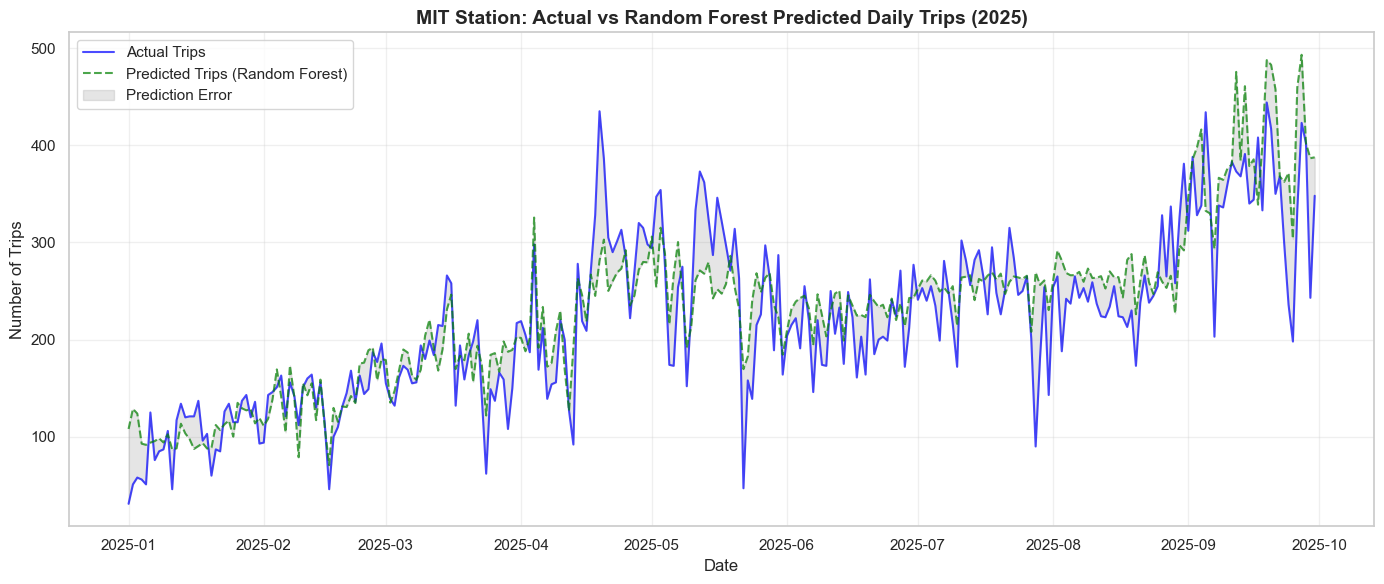

✓ Random Forest prediction comparison plot saved


In [52]:
# Visualize predictions over time for MIT
mit_rf_sorted = mit_rf.sort_values("date")

plt.figure(figsize=(14, 6))
plt.plot(mit_rf_sorted["date"], mit_rf_sorted["trip_count"], linewidth=1.5, alpha=0.7, color="blue", label="Actual Trips")
plt.plot(mit_rf_sorted["date"], mit_rf_sorted["predicted_rf"], linewidth=1.5, alpha=0.7, color="green", linestyle="--", label="Predicted Trips (Random Forest)")
plt.fill_between(mit_rf_sorted["date"], mit_rf_sorted["trip_count"], mit_rf_sorted["predicted_rf"], alpha=0.2, color="gray", label="Prediction Error")
plt.title("MIT Station: Actual vs Random Forest Predicted Daily Trips (2025)", fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../visualizations/predictions_vs_actual_rf.png", dpi=200, bbox_inches="tight")
plt.show()

print("✓ Random Forest prediction comparison plot saved")

In [53]:
comparison = pd.DataFrame([
    {
        "Model": "Linear Regression",
        "Train_RMSE": train_rmse, "Test_RMSE": test_rmse,
        "Train_MAE": train_mae, "Test_MAE": test_mae,
        "Train_R2": train_r2, "Test_R2": test_r2,
    },
    {
        "Model": "Random Forest",
        "Train_RMSE": rf_train_rmse, "Test_RMSE": rf_test_rmse,
        "Train_MAE": rf_train_mae, "Test_MAE": rf_test_mae,
        "Train_R2": rf_train_r2, "Test_R2": rf_test_r2,
    },
    {
        "Model": "XGBoost",
        "Train_RMSE": xgb_train_rmse, "Test_RMSE": xgb_test_rmse,
        "Train_MAE": xgb_train_mae, "Test_MAE": xgb_test_mae,
        "Train_R2": xgb_train_r2, "Test_R2": xgb_test_r2,
    },
])

cols = ["Train_RMSE", "Test_RMSE", "Train_MAE", "Test_MAE", "Train_R2", "Test_R2"]
comparison[cols] = comparison[cols].round(3)
print(comparison.to_string(index=False))

            Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2
Linear Regression      10.083     14.395     11.017    11.666     0.752    0.731
    Random Forest       7.535     13.744      4.464     7.939     0.955    0.819
          XGBoost       7.901     13.107      5.279     7.743     0.951    0.835
